## 06. PyTorch Transfer Learning

So far, we’ve seen how to build models from scratch and train them on datasets like **FashionMNIST** or even on custom datasets. While this works well for small problems, training a deep neural network from the ground up often requires:

1. **Lots of data** – millions of labeled examples.
2. **Lots of compute power** – GPUs or TPUs running for days or weeks.
3. **Lots of time** – to tune and optimize the model.

In practice, many people don’t have access to such large datasets or compute resources. Instead, a common approach in deep learning is to use **transfer learning**.

---

### What is Transfer Learning?

**Transfer learning** is the process of taking a pre-trained model (a model that’s already been trained on a large dataset, like ImageNet with millions of images) and adapting it to your specific problem.

Instead of starting from scratch, we leverage the **knowledge** the model has already learned and apply it to new tasks.

---

### Why Use Transfer Learning?

* **Saves time** – You don’t need to train huge models from the ground up.
* **Works with small datasets** – Pre-trained models already know useful features, so they can generalize better with fewer training examples.
* **Improves performance** – Transfer learning often gives better accuracy compared to training from scratch, especially on limited data.

---

### Examples of Transfer Learning

* Using a pre-trained **ResNet** (trained on ImageNet) to classify medical images.
* Fine-tuning **BERT** (trained on billions of text samples) for a sentiment analysis task.
* Adapting **VGG** or **MobileNet** to recognize custom objects, such as foods, animals, or products.

---

👉 In this lesson, we’ll learn how to apply **transfer learning in PyTorch**, explore different strategies (feature extraction vs fine-tuning), and see how it can help us solve problems faster and more effectively.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms
from torchinfo import summary

from going_modular import data_setup, engine

/opt/anaconda3/envs/env_pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setting device for mac which is METAL GPU
device = "mps" if torch.backends.mps.is_available() else "cpu"

# sef default seeding to 42
SEED = 42

In [3]:
import os 
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Declaring the directories for train and test
train_dir = image_path / "train"
test_dir = image_path / "test"

### Why Normalize?

1. Neural networks work better when inputs are in a **consistent range**.
2. Pretrained models in PyTorch (e.g., from `torchvision.models`) expect images to be normalized in the same way they were trained.
3. If I don’t normalize with the right values, the model may give poor results, because the input distribution will not match what it has learned.

---

### What does this line mean?

```python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])
```

* `mean=[0.485, 0.456, 0.406]` → average RGB values of the **ImageNet dataset** (the dataset used to train most pretrained models).
* `std=[0.229, 0.224, 0.225]` → standard deviation of RGB values in ImageNet.
* It standardizes each channel:

  ```
  output[channel] = (input[channel] - mean[channel]) / std[channel]
  ```

  So the data will be centered around 0 with a controlled variance.

---

### Intuition

* Without normalization → pixel values are usually \[0, 1] (after `ToTensor`).
* With normalization → values are adjusted to what the pretrained model “expects”.
* Example:

  * If a red pixel = 0.8, then normalized red = (0.8 - 0.485) / 0.229 ≈ 1.37.
  * This ensures the input distribution is **aligned with training distribution**.

---

### Rule of Thumb

* If I use a pretrained model → I must use **ImageNet normalization** (above values).
* If I train a model from scratch on my own dataset → I can compute the mean/std of my dataset and use those.

In [4]:
manual_transforms = transforms.Compose([transforms.Resize((224, 224)), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                             std=[0.229, 0.224, 0.225])])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, 
                                                                               test_dir=test_dir, 
                                                                               transform=manual_transforms, 
                                                                               batch_size=32, 
                                                                               num_workers=os.cpu_count())

In [5]:
# class_names

In [6]:
weights = torchvision.models.EfficientNet_B1_Weights.IMAGENET1K_V1
weights

EfficientNet_B1_Weights.IMAGENET1K_V1

In [7]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[240]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=auto_transforms,
                                                                              batch_size=32,
                                                                              num_workers=os.cpu_count())

test_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x124cd91f0>,
 ['pizza', 'steak', 'sushi'])

In [9]:
model = torchvision.models.efficientnet_b1(weights=weights)

In [10]:
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [11]:
# freezing all model pretrained details
for param in model.features.parameters(): param.requires_grad = False

In [12]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

output_shape = len(class_names)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=output_shape,bias=True)
).to(device)

In [13]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

In [15]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

from timeit import default_timer as timer 
start_time = timer()


results = engine.train(model, 
                       train_dataloader, 
                       test_dataloader, 
                       optimizer, 
                       loss_fn, 
                       epochs=3, 
                       device=device)

end_time = timer()

print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 # model: torch.nn.modules.module.Module,
 #    train_dataloader: torch.utils.data.dataloader.DataLoader,
 #    test_dataloader: torch.utils.data.dataloader.DataLoader,
 #    optimizer: torch.optim.optimizer.Optimizer,
 #    loss_fn: torch.nn.modules.module.Module,
 #    epochs: int,
 #    device: torch.device,

 33%|███████████████                              | 1/3 [01:13<02:27, 73.53s/it]

Epoch: 1 | train_loss: 1.1097 | train_acc: 0.3125 | test_loss: 1.1088 | test_acc: 0.3046


 67%|██████████████████████████████               | 2/3 [02:24<01:11, 71.73s/it]

Epoch: 2 | train_loss: 1.1208 | train_acc: 0.2969 | test_loss: 1.0716 | test_acc: 0.4142


100%|█████████████████████████████████████████████| 3/3 [03:33<00:00, 71.19s/it]

Epoch: 3 | train_loss: 1.0968 | train_acc: 0.3086 | test_loss: 1.0701 | test_acc: 0.4395
[INFO] Total training time: 213.754 seconds


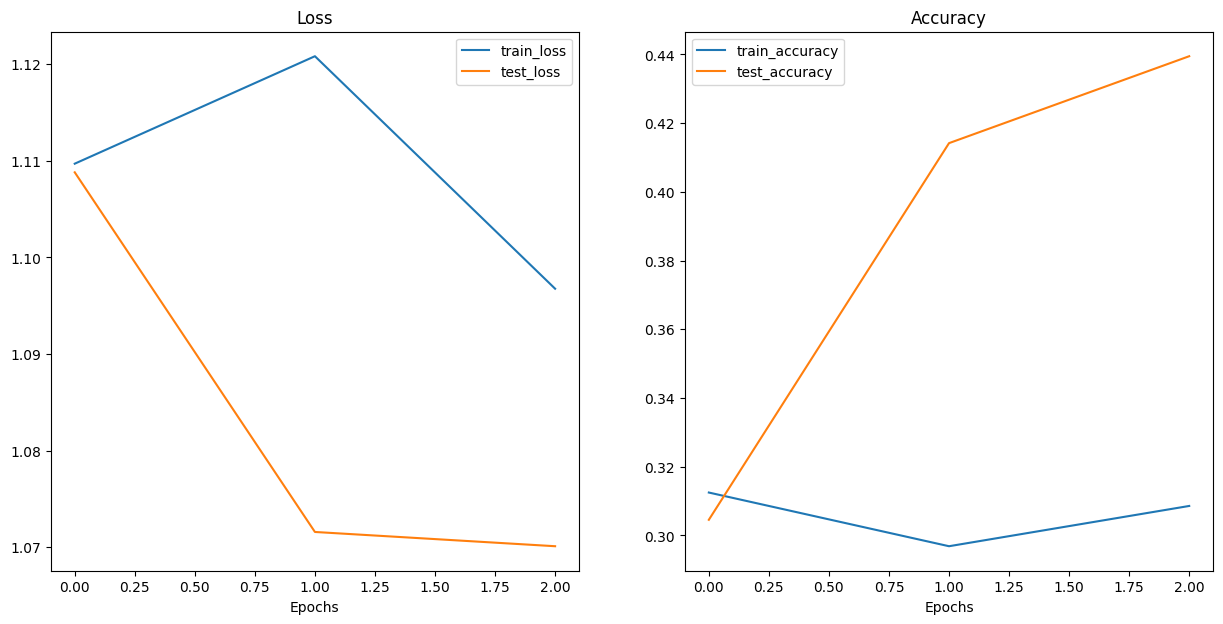

In [16]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [17]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

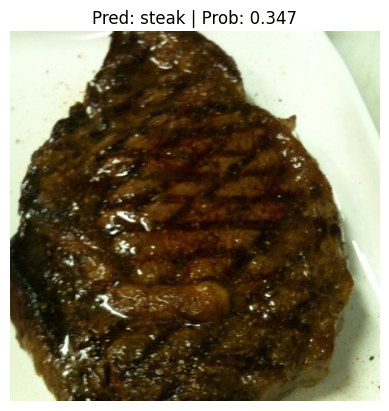

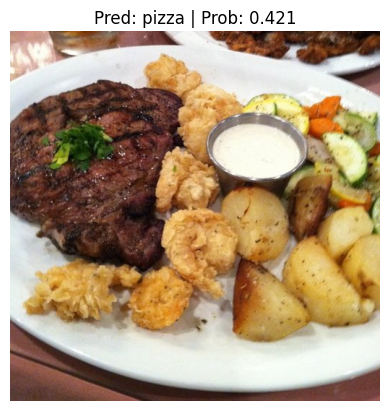

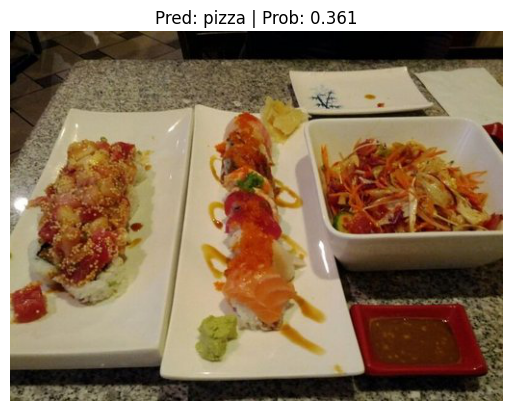

In [18]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

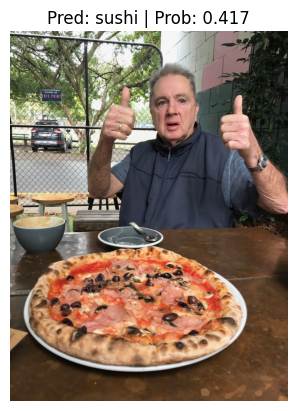

In [19]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)